In [ ]:
# required imports for the given decision tree and deep neural network

import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, neighbors
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation

import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# importing dataset to use for the code from google drive (this was done on google colab)
# df = pd.read_csv("/content/drive/MyDrive/card_transdata.csv")
df = pd.read_csv("/content/drive/MyDrive/card_transdata.csv")

In [ ]:
# to visualuze the dataset, we put the information into a table
df.describe().style.background_gradient(cmap = "viridis")

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: >

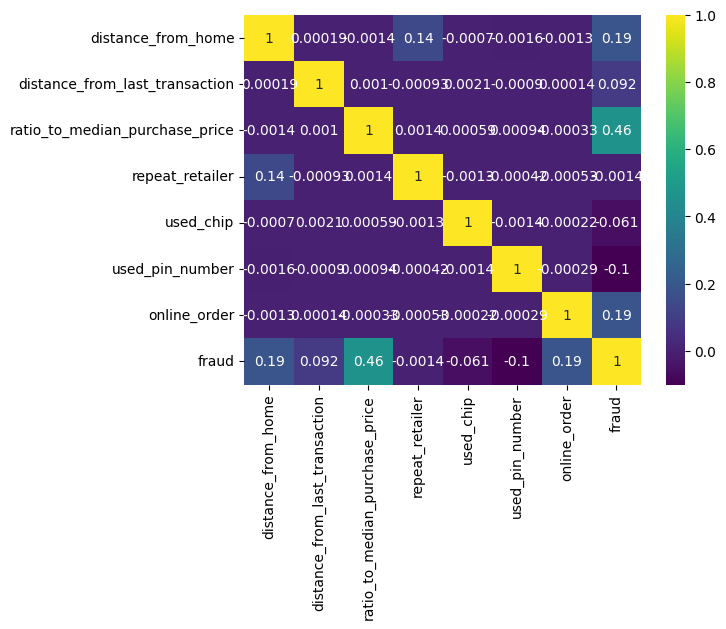

In [ ]:
# we include the visualization for the correlation between the different features
correlation = df.corr()
sns.heatmap(correlation, xticklabels = correlation.columns, yticklabels = correlation.columns, annot = True, cmap = "viridis")

In [ ]:
# we split the dataset into X and y so that we can include the different features and the label for the features
X = np.array(df.drop(columns = "fraud"))
y = np.array(df["fraud"])

In [ ]:
# we split the data into the training and the testing set data and we include that we shuffle the data points
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state = 123, shuffle = True)
scale = MinMaxScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

In [ ]:
# we then generate the decision tree and we include the random state to be 5
decision_tree = DecisionTreeClassifier(random_state = 5)
decision_tree.fit(X_train, y_train)
y_predicted = decision_tree.predict(X_test)

In [ ]:
# we create the confusion matrix and we display it
conf_matrix = confusion_matrix(y_test, y_predicted)

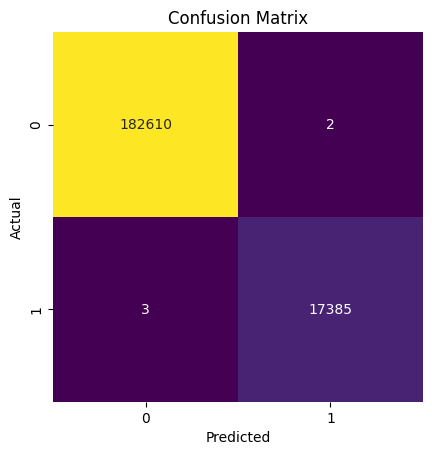

In [ ]:
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="viridis", cbar=False, square=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# we print the classification report and we display the results
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    182612
         1.0       1.00      1.00      1.00     17388

    accuracy                           1.00    200000
   macro avg       1.00      1.00      1.00    200000
weighted avg       1.00      1.00      1.00    200000



In [ ]:
# we include the precision, accuracy, recall, and f1_score metrics for the decision tree below
precision = precision_score(y_test, y_predicted)
accuracy = accuracy_score(y_test, y_predicted)
recall = recall_score(y_test, y_predicted)
f1 = f1_score(y_test, y_predicted)

# Create a DataFrame
metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Accuracy', 'Recall', 'F1 Score'],
    'Score': [precision, accuracy, recall, f1]
})

print(metrics_df)

      Metric     Score
0  Precision  0.999885
1   Accuracy  0.999975
2     Recall  0.999827
3   F1 Score  0.999856


In [ ]:
# DNN

In [ ]:
df['Log_home'] = np.log10(df['distance_from_home'])
df['Log_trans'] = np.log10(df['distance_from_last_transaction'])
df['Log_ratio'] = np.log10(df['ratio_to_median_purchase_price'])

In [ ]:
X = df.drop(columns = ['fraud', 'Log_home','Log_trans','Log_ratio'])
y = df['fraud']

# Splitting the data into test and train

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size = 0.2, stratify = y_train)

# It is important to only fit the scaler to the training data, otherwise you are leaking
# information about the global distribution of variables (which is influenced by the test set)
# into the train set.

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Getting class weights

class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(y_train),y = y_train)
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=len(X.columns)))
model.add(Dropout(0.3))
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                512       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [ ]:
model.fit(X_train, y_train, epochs=2, \
                    validation_data=(scaler.transform(X_val),y_val), \
                    verbose = True, class_weight = class_weights)

Epoch 1/2
20000/20000 [==============================] - 88s 4ms/step - loss: 0.0829 - accuracy: 0.9651 - val_loss: 0.1027 - val_accuracy: 0.9614
Epoch 2/2
20000/20000 [==============================] - 73s 4ms/step - loss: 0.0475 - accuracy: 0.9816 - val_loss: 0.1077 - val_accuracy: 0.9562


In [ ]:
y_pred_temp = model.predict(scaler.transform(X_test))

6250/6250 [==============================] - 12s 2ms/step


6250/6250 [==============================] - 15s 2ms/step


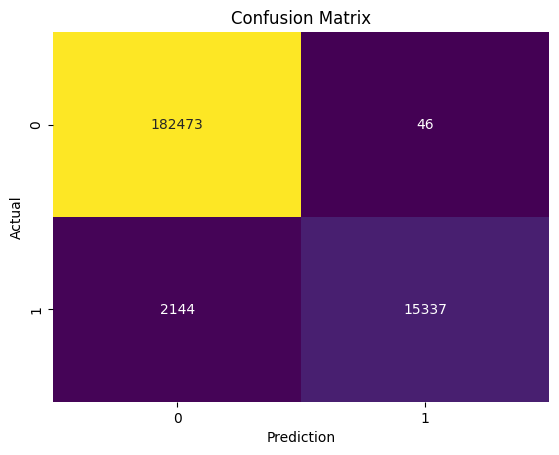

In [ ]:
y_pred_temp = model.predict(scaler.transform(X_test))
threshold = 0.995

# Apply threshold directly using NumPy operations
y_pred = (y_pred_temp > threshold).astype(int)

# Create confusion matrix
c_matrix = confusion_matrix(y_test, y_pred)

# Create confusion matrix heatmap using seaborn
ax = sns.heatmap(c_matrix, annot=True, cbar=False, cmap='viridis', fmt='d')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title('Confusion Matrix')
plt.show()

In [ ]:
# we include the precision, accuracy, recall, and f1_score metrics for the decision tree below
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Create a DataFrame
metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Accuracy', 'Recall', 'F1 Score'],
    'Score': [precision, accuracy, recall, f1]
})

print(metrics_df)

      Metric     Score
0  Precision  0.997010
1   Accuracy  0.989050
2     Recall  0.877353
3   F1 Score  0.933362


In [ ]:
X = np.array(df.drop(columns = "fraud"))
y = np.array(df["fraud"])

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state = 123, shuffle = True)
scale = MinMaxScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

In [ ]:
random_forest = RandomForestClassifier(n_estimators=10, random_state =0, max_depth = 2)
random_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, n_estimators=10, random_state=0)

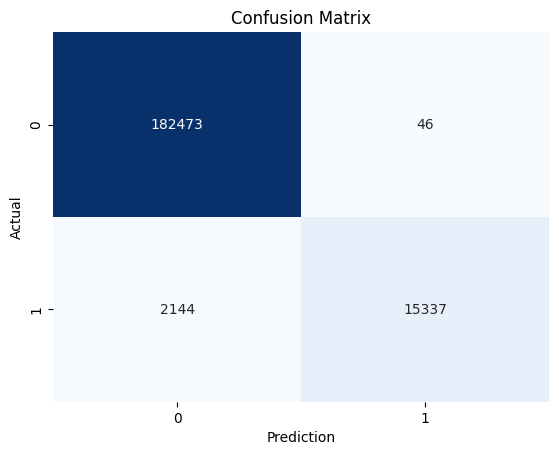

      Metric     Score
0  Precision  0.901475
1   Accuracy  0.968315
2     Recall  0.713538
3   F1 Score  0.796572


In [ ]:
y_pred = random_forest.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

# Create confusion matrix heatmap using seaborn
ax = sns.heatmap(c_matrix, annot=True, cbar=False, cmap='Blues', fmt='d')
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
ax.set_title('Confusion Matrix')
plt.show()

# Accuracy predictions
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Create a DataFrame
metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Accuracy', 'Recall', 'F1 Score'],
    'Score': [precision, accuracy, recall, f1]
})

print(metrics_df)

References Tile: